# Pulsebuilding for QCoDeS part II

This set of tutorials covers the offline construction of pulse sequences from idea to numpy array to awg file. No instrument is required. In part one, we deal with individual pulse sequence elements. Part two covers sequences and awg files.

## The Sequence Object

In this part of the tutorial, **blueprints** are collected together to form a fully-fletched pulse **sequence**.
A sequence may internally **forge** **elements** and output the corresponding arrays, and it can even compile an awg file. It can (and indeed should) be updated with instrument parameters to correctly translate blueprint voltages into awg binary format and get the timing right via the correct sample rate. 

([-] means not implemented yet)

It allows for setting different modifications for the output:
  
  * Cable transfer function compensation [-]
  * Cable length difference compensation (channel delays) [-]

It supports some higher-order sequence commands:

  * Setting and getting across channels [-]
  * Creating a sequence with a varying parameter [-]

In [1]:
%matplotlib nbagg
import qcodes.instrument_drivers.tektronix.pulsebuilding as pb
import numpy as np

ramp = pb.PulseAtoms.ramp
sine = pb.PulseAtoms.sine
gauss = pb.PulseAtoms.gaussian

### Construction

In [2]:
# simple case, some blueprints

tophat = pb.BluePrint([ramp, ramp, ramp],
                      [(0, 0), (0, 1), (0, 0)],
                      ['', '', ''])

wiggleroof1 = pb.BluePrint([ramp, sine, ramp],
                           [(1, 0), (5, 1, 1), (-1, 1)],
                           ['', '', ''])
wiggleroof2 = wiggleroof1.copy()
wiggleroof2.changeArg('sine', 'freq', 2.5)

dip = pb.BluePrint([ramp, gauss, ramp],
                   [(1, 0), (-1, 0.1, 0, 1), (-1, 1)],
                   ['', '', ''])

durations = [1, 1, 1]
seq = pb.Sequence()
seq.setSR(200)
# add (sub)elements by channel, sequence position
#first element
seq.addElement(1, 1, tophat, durations)
seq.addElement(2, 1, wiggleroof1, durations)
seq.addElement(4, 1, tophat, durations)
# second element
seq.addElement(1, 2, wiggleroof2, durations)
seq.addElement(2, 2, dip, durations)
seq.addElement(4, 2, tophat, durations)

# add some sequencing information
seq.setSequenceSettings(1, 1, 1, 1, 1)

In [3]:
# We may check the the sequence contains consistent build instructions, i.e. that all channels with elements
# on them have the same number of elements, that there are no missing elements, and that the elements have the same
# length
seq.checkConsistency()

True

<IPython.core.display.Javascript object>


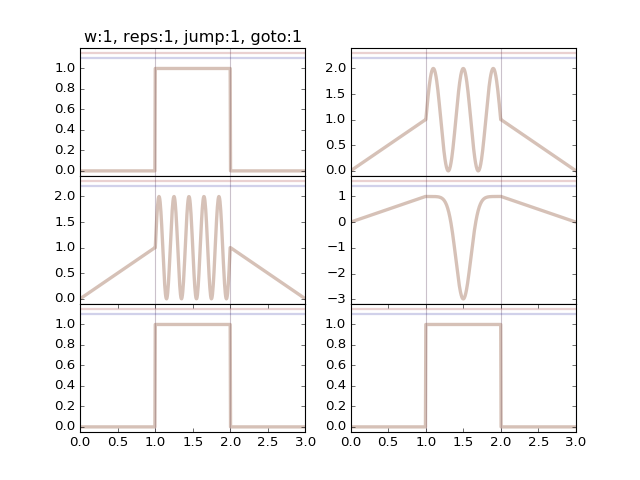

In [4]:
seq.plotSequence()

## Higher-order functions

In [10]:
# Create a range of elements of a specific channel varying some parameter

# Let's say we want a 'dip' element with varying widths

# First we make _some_ iterable (list, array, set, dict.keys, range, ...) object containing the values
widths1 = [0.1, 0.15, 0.05, 0.2, 0.25]
widths2 = np.linspace(0.01, 0.5, 5)

# Then a blueprint forming the basis of the variation
basisbp = pb.BluePrint([ramp, gauss, ramp],
                       [(1, 0), (-1, 0.1, 0, 1), (-1, 1)],  # Note: this 'width' value is never used
                       ['', 'varyme', ''])  # Better safe than sorry; use a unique name

# Of course some durations
durations = [1, 2, 1]

# And then a sequence
varyseq = pb.Sequence()
varyseq.setSR(500)

# And the magic function to create all the elements
varyseq.setSeveralElements(1, basisbp, ('varyme', 'sigma'), durations, widths1)

# We may of course assign a different variation to a different channel
varyseq.setSeveralElements(2, basisbp, ('varyme', 'sigma'), durations, widths2)
varyseq.plotSequence()

<IPython.core.display.Javascript object>

In [6]:
varyseq.checkConsistency(verbose=True)

True